https://www.kaggle.com/datasets/prkhrawsthi/twitter-sentiment-dataset-3-million-labelled-rows

# SEMANTIC CATEGORIZATION

rather than assigning rank to different text which has narrow scope of implementation, categorization has a much wider application like extracting meaning, intent, category, main information, etc. In terms of texts, our interest is to group more than to quantify it

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/# DATA SCIENCE/my project/NLP/twitter_dataset.csv')
df = df_original.copy()

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142403 entries, 0 to 3142402
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   tweet       object 
 2   sentiment   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 71.9+ MB


In [ ]:
df['sentiment'].unique()

array([ 0.,  1.,  2., nan])

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

Unnamed: 0     0
tweet          0
sentiment     82
dtype: int64

<Axes: >

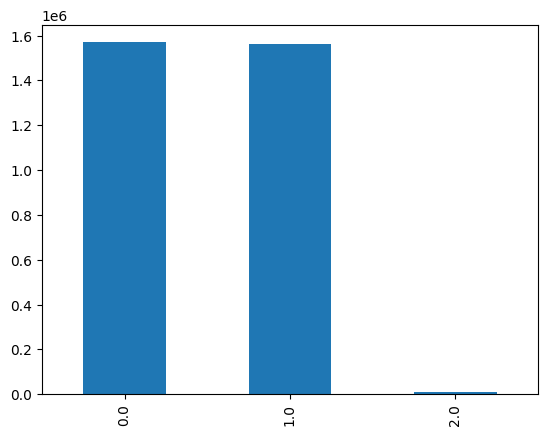

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')

In [ ]:
df['sentiment'].value_counts()

0.0    1570067
1.0    1561529
2.0      10725
Name: sentiment, dtype: int64

In [ ]:
df.sample(5)

,Unnamed: 0,tweet,sentiment
1270066,1270066,"@MazaNajle Nonverbal communication, platonic a...",1.0
11493,11493,So I didn't go Jogging (yet) Got caught up mak...,0.0
2985978,2985978,awww tru confessions makes me love shia even more,1.0
838205,838205,Gotta go rescue @dynila from my child... poor ...,1.0
530278,530278,toothache ! uhhh gosh,0.0


# DATA PREPROCESSING

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df.sample(frac=1)

# Remove 500k row of sentiment 0 and 500k row of sentiment 1
df = df.groupby('sentiment').apply(lambda x: x.iloc[:-500000] if len(x) > 500000 else x)

In [ ]:
df['sentiment'].value_counts()

0.0    1070067
1.0    1061529
2.0      10725
Name: sentiment, dtype: int64

In [ ]:
df.shape

(2142321, 2)

### < split train, val, test >

In [ ]:
X = df['tweet']
Y = df['sentiment']

In [ ]:
# 80% train, 10% validation, 10% test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=33)

# Split the temporary data into validation (50%) and test (50%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=33)

### < remove special characters >

In [ ]:
p = re.compile(r'[^a-zA-Z0-9\s]')

X_train = [p.sub('', x) for x in X_train]

In [ ]:
X_train = pd.Series(X_train, name='Text')

### < convert all word to lowercase >

In [ ]:
# larger vocab size without conversion
X_train = X_train.str.lower()

### < tokenize the texts >

In [ ]:
total_words = X_train.str.split().apply(len).sum()
longest_words = max(X_train.str.split().apply(len))
print("Total words in the Series:", total_words)
print("longest word count in the Series:", longest_words)

Total words in the Series: 22673501
longest word count in the Series: 58


In [ ]:
tokenizer = Tokenizer(oov_token="<UKN>")
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
word_index = tokenizer.word_index

# Get the unique tokens and their count
unique_tokens = list(word_index.keys())
vocab_size = len(unique_tokens)

# Print the vocabulary size
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 613623


### < padding the sentences with keras pad_sequences>

In [ ]:
maxlen = 50  # arbitrary setting the max len to be 50

In [ ]:
X_train = keras.utils.pad_sequences(X_train, maxlen=maxlen)

In [ ]:
X_train[1:5].shape

(4, 50)

# MODEL DEFINITION

In [ ]:
# transformer block has 2 main component, the encoder and decoder attention
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
vocab_size = 614638 + 1 # tot unique token include 1 for oov
embed_dim = 32  # embedding size for each token
num_heads = 2  # amount of attention heads
ff_dim = 32  # hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,)) # input is a 1d tensor with 200 element
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(124, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 token_and_position_embeddi  (None, 50, 32)            19670048  
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 50, 32)            10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 124)               4092  

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# MODEL TRAINING

In [ ]:
# indices not in range because the vocab size is not equal to total token
# using big batch size for faster convergence with lower epochs
model.fit(X_train, Y_train, epochs=8, batch_size=128, validation_split=0.2)

Epoch 1/8
10712/10712 [==============================] - 243s 22ms/step - loss: 0.4544 - accuracy: 0.7880 - val_loss: 0.4205 - val_accuracy: 0.8092
Epoch 2/8
10712/10712 [==============================] - 198s 18ms/step - loss: 0.3489 - accuracy: 0.8502 - val_loss: 0.4591 - val_accuracy: 0.7906
Epoch 3/8
10712/10712 [==============================] - 187s 18ms/step - loss: 0.2924 - accuracy: 0.8765 - val_loss: 0.4835 - val_accuracy: 0.7895
Epoch 4/8
10712/10712 [==============================] - 189s 18ms/step - loss: 0.2651 - accuracy: 0.8868 - val_loss: 0.4579 - val_accuracy: 0.8086
Epoch 5/8
10712/10712 [==============================] - 198s 18ms/step - loss: 0.2493 - accuracy: 0.8933 - val_loss: 0.4774 - val_accuracy: 0.8037
Epoch 6/8
10712/10712 [==============================] - 208s 19ms/step - loss: 0.2351 - accuracy: 0.8992 - val_loss: 0.4872 - val_accuracy: 0.8057
Epoch 7/8
10712/10712 [==============================] - 198s 18ms/step - loss: 0.2226 - accuracy: 0.9048 - val_

# MODEL EVAL

In [ ]:
X_test = [p.sub('', x) for x in X_test]
X_test = pd.Series(X_test, name='Text')

X_test = X_test.str.lower()
X_test = tokenizer.texts_to_sequences(X_test)
X_test = keras.utils.pad_sequences(X_test, maxlen=maxlen)

6695/6695 [==============================] - 31s 5ms/step


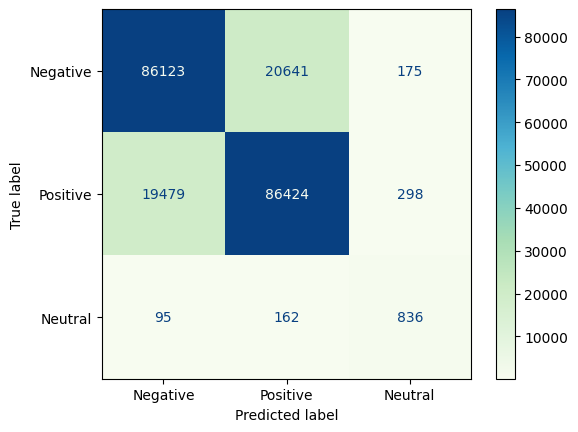

<Figure size 2000x2000 with 0 Axes>

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive", "Neutral"])#
disp.plot(cmap='GnBu')
plt.figure(figsize=(20, 20))
plt.show()

In [ ]:
# classification report

report = classification_report(Y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81    106939
         1.0       0.81      0.81      0.81    106201
         2.0       0.64      0.76      0.70      1093

    accuracy                           0.81    214233
   macro avg       0.75      0.79      0.77    214233
weighted avg       0.81      0.81      0.81    214233



# INFERENCE

In [ ]:
X_val.iloc[10]

'maybe it is a silent thank you hi jen you must know my friend'

In [ ]:
test_sample = '''maybe it is a silent thank you hi jen you must know my friend.'''

test_sample = p.sub('', test_sample)
test_sample = test_sample.lower()

In [ ]:
test_sample = tokenizer.texts_to_sequences([test_sample])
test_sample = keras.utils.pad_sequences(test_sample, maxlen=50)

In [ ]:
class_label = ''
class_prob = np.argmax(model.predict(test_sample), axis=-1)
if class_prob == 0:
  print('Negative')
elif class_prob == 1:
  print('Positive')
elif class_prob == 2:
  print('Neutral')

1/1 [==============================] - 0s 48ms/step
Positive


# MODEL SAVING


In [ ]:
model.save('transformer_model.keras')